# Import libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from time import perf_counter
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.set_random_seed(0)
np.random.seed(0)
import itertools
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Load Data

In [2]:
batch_size = 128
img_height = 224
img_width = 224

In [5]:
#Load training dataset
train_path="/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_path="/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid"
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
   train_path,
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

# loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
   valid_path ,
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


# Total Number of  disease 

In [4]:
class_names = training_ds.class_names
print(class_names)
print("\nTotal disease classes are: {}".format(len(class_names)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

# Shape of dataset

In [6]:
diseases_train = os.listdir(train_path)
diseases_valid = os.listdir(valid_path)
print("Size of Train Data",len(diseases_train))
print("Size of Test Data",len(diseases_valid))

Size of Train Data 38
Size of Test Data 38


In [7]:
plants = []
NumberOfDiseases = 0
for plant in class_names:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

# Number of Unique Plants

In [8]:
#unique plants name
print("Number of Unique plants:" ,len(plants))
print(f"Unique Plants are: \n{plants}")

Number of Unique plants: 14
Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']


# Number of Unique Disease

In [9]:
#Number of unique disease
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


# Number of Image for each disease

In [10]:
# Number of images for each disease 
nums = {}
for disease in class_names:
    nums[disease] = len(os.listdir(train_path + '/' + disease))
    img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Apple___Apple_scab                                           2016
Apple___Black_rot                                            1987
Apple___Cedar_apple_rust                                     1760
Apple___healthy                                              2008
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Corn_(maize)___Common_rust_                                  1907
Corn_(maize)___Northern_Leaf_Blight                          1908
Corn_(maize)___healthy                                       1859
Grape___Black_rot                                            1888
Grape___Esca_(Black_Measles)                                 1920
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Peach___Bacterial_spot                                       1838
Peach___healthy                                              1728
Pepper,_bell___Bacterial_spot                                1913
Pepper,_bell___healthy                                       1988
Potato___Early_blight                                        1939
Potato___Late_blight                                         1939
Potato___healthy                                             1824
Raspberry___healthy                                          1781
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Strawberry___Leaf_scorch                                     1774
Strawberry___healthy                                         1824
Tomato___Bacterial_spot                                      1702
Tomato___Early_blight                                        1920
Tomato___Late_blight                                         1851
Tomato___Leaf_Mold                                           1882
Tomato___Septoria_leaf_spot                                  1745
Tomato___Spider_mites Two-spotted_spider_mite                1741
Tomato___Target_Spot                                         1827
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Tomato_mosaic_virus                                 1790
Tomato___healthy                                             1926

# Plotting number of images available for each disease

Text(0.5, 1.0, 'Images per each class of plant disease')

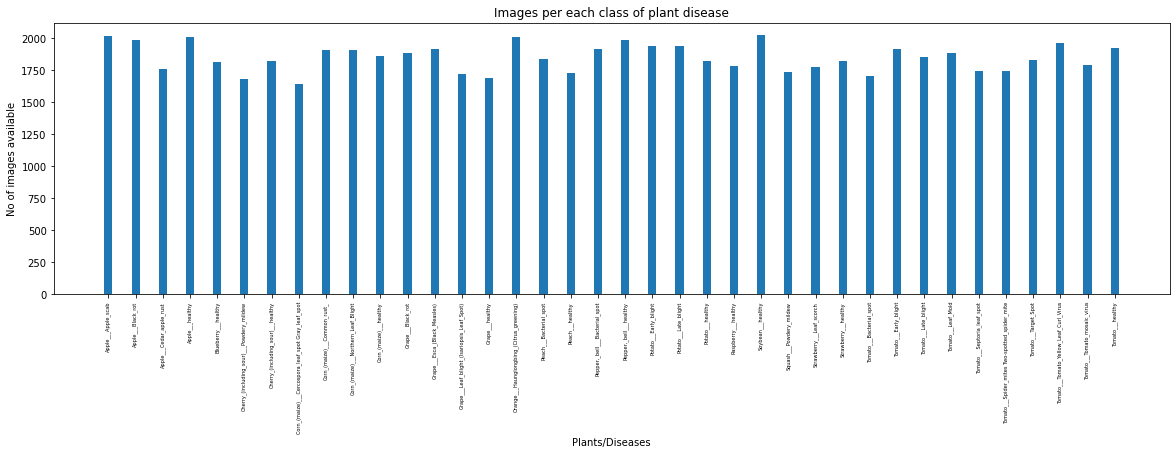

In [11]:
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, class_names, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

# Show some image from dataset

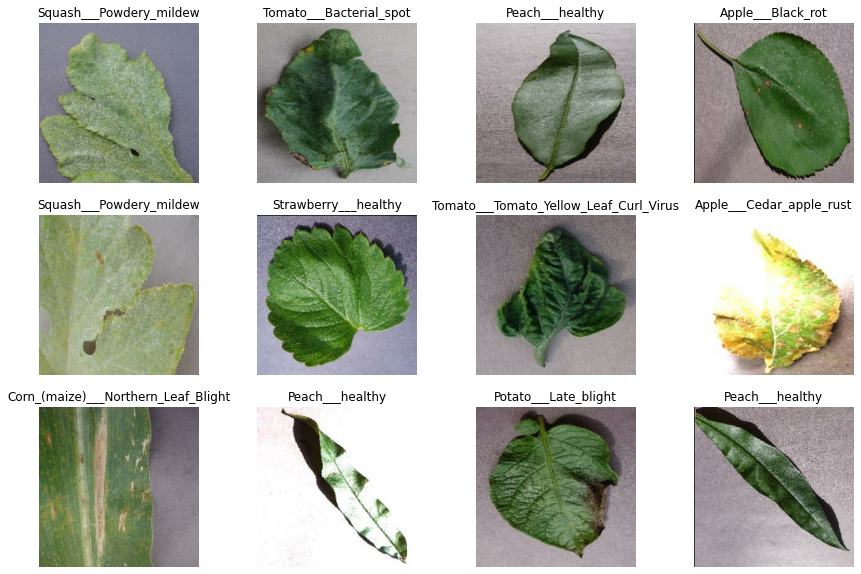

In [13]:
plt.figure(figsize=(15,10))
for image_batch,labels_batch in training_ds.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Image Processing**

## Image Acquisition

In [19]:
directory="../input/new-plant-diseases-dataset/test/test"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
print(len(files))

33


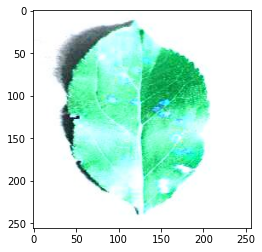

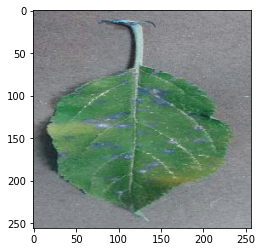

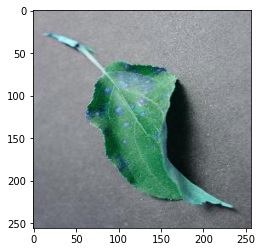

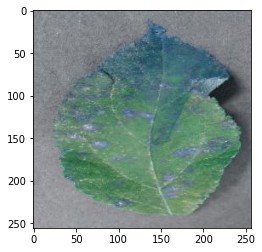

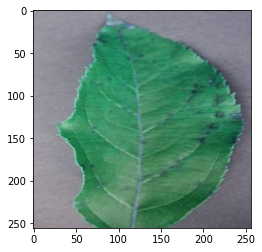

In [20]:
for i in range(5):
    img=cv2.imread(files[i])
    plt.imshow(img)
    plt.show()

## Color Image Processing

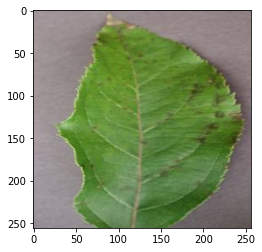

In [21]:
cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cvt)
plt.show()

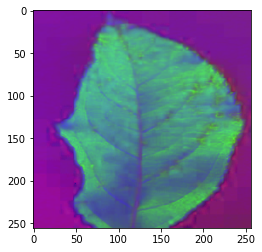

In [22]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_img)
plt.show()

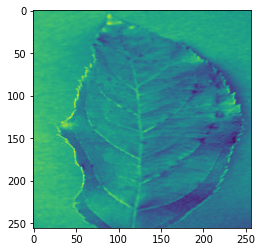

In [23]:
gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)
plt.show()

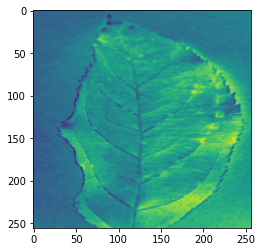

In [24]:
inverted_image = cv2.bitwise_not(gray_image)
plt.imshow(inverted_image)
plt.show()

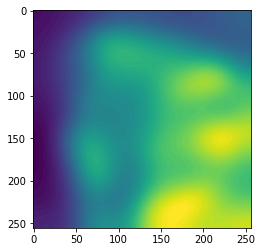

In [25]:
blurred = cv2.GaussianBlur(inverted_image, (111,111),0)
plt.imshow(blurred)
plt.show()

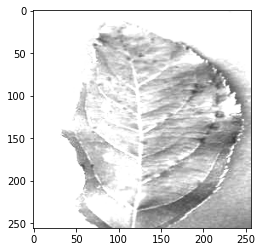

In [26]:
sketch_image=cv2.divide(gray_image,inverted_image, scale=256.0)
pencil_sketch=cv2.cvtColor(sketch_image, cv2.COLOR_BGR2RGB)
plt.imshow(pencil_sketch)
#plt.axis('off')
plt.show()

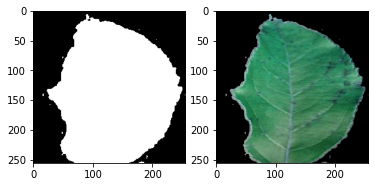

In [27]:
lower_green = np.array([25,0,20])
upper_green = np.array([100,255,255])
mask = cv2.inRange(hsv_img, lower_green, upper_green)
result = cv2.bitwise_and(img, img, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

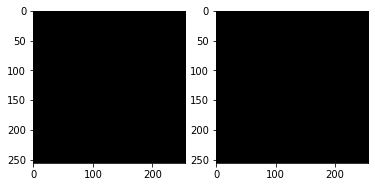

In [28]:
lower_brown = np.array([10,0,10])
upper_brown = np.array([30,255,255])
disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
disease_result = cv2.bitwise_and(img, img, mask=disease_mask)
plt.subplot(1, 2, 1)
plt.imshow(disease_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(disease_result)
plt.show()

## Image Enhancement

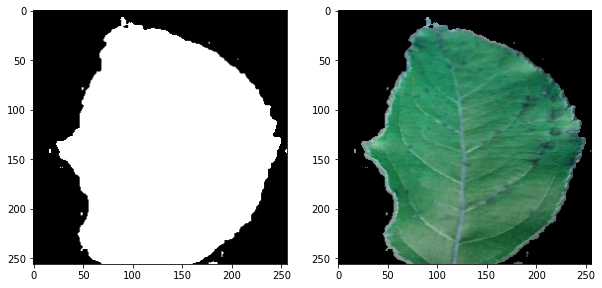

In [29]:
final_mask = mask + disease_mask
final_result = cv2.bitwise_and(img, img, mask=final_mask)
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

## Image Restoration

In [30]:
# Noise Image

def noise(img,snr):
    h=img.shape[0]
    w=img.shape[1]
    img1=img.copy()
    sp=h*w
    NP=int(sp*(1-snr))
    for i in range (NP):
        randx=np.random.randint(1,h-1)
        randy=np.random.randint(1,w-1)
        if np.random.random()<=0.5:
            img1[randx,randy]=0
        else:
            img1[randx,randy]=255
    return img1

In [31]:
img_noise = noise(img, 0.6)

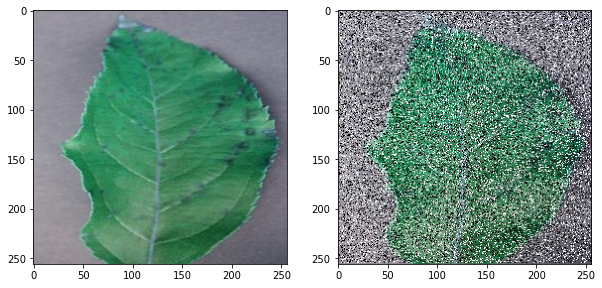

In [32]:
# plotting image - Image Noise

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img_noise,cmap="gray")
plt.show()

In [33]:
median = cv2.medianBlur(img_noise, 5)

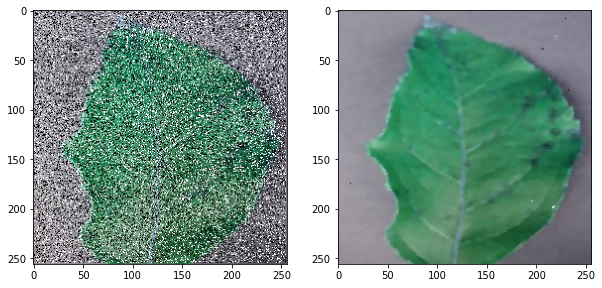

In [34]:
# plotting image - Median Filter

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img_noise,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(median,cmap="gray")
plt.show()

In [35]:
img_gauss = cv2.GaussianBlur(img_noise, (5,5),0)

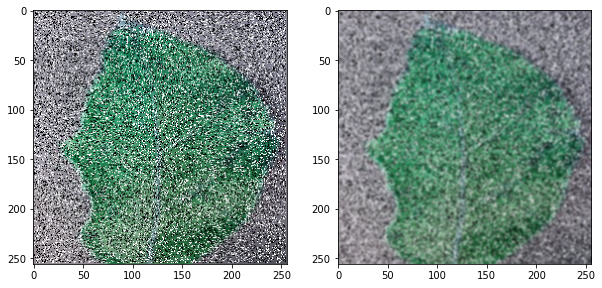

In [36]:
# plotting image - Gaussian Filter

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img_noise,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img_gauss,cmap="gray")
plt.show()

Rotat

## Image Compression

In [30]:
BGRImage = cv2.resize(img, (100, 100))
YCrCbImage = cv2.cvtColor(BGRImage, cv2.COLOR_BGR2YCR_CB)
Y, Cb, Cr = YCrCbImage[:,:,0], YCrCbImage[:,:,1], YCrCbImage[:,:,2]
Y = np.array(Y).astype(np.int16)
Cb = np.array(Cb).astype(np.int16)
Cr = np.array(Cr).astype(np.int16)
Y, Cb, Cr = Y - 128, Cb - 128, Cr - 128
print(img.shape)
print(BGRImage.shape)

(256, 256, 3)
(100, 100, 3)


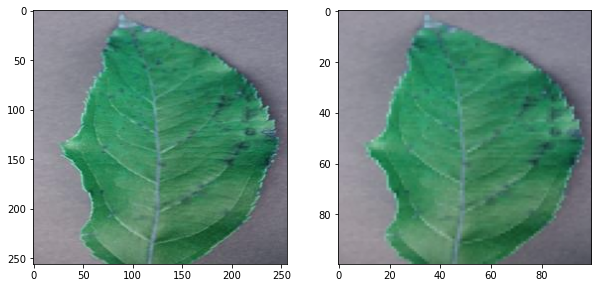

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(BGRImage)
plt.show()

# Image segmentation

## 1. Image Segmentation using K-means

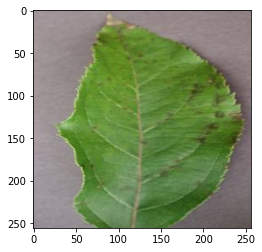

In [32]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [33]:
#Preprocessing the Image
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

In [34]:
#Defining Parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10

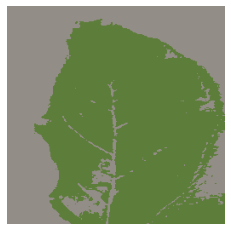

In [35]:
#Applying K-Means for Image Segmentation
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

plt.axis('off')
plt.imshow(result_image)

## 2. Image Segmentation using Contour Detection

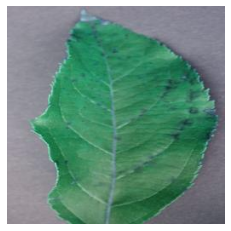

In [36]:

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(256,256))

plt.axis('off');
plt.imshow(img)

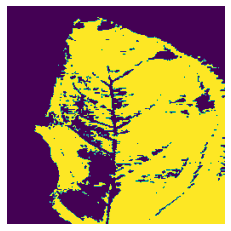

In [37]:
#Applying Image Thresholding
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)

plt.axis('off')
plt.imshow(thresh)

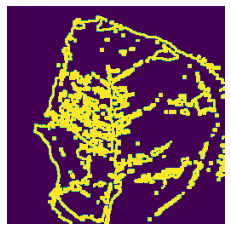

In [39]:
#Detecting Edges
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

plt.axis('off')
plt.imshow(edges)
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

plt.axis('off')
plt.imshow(edges)

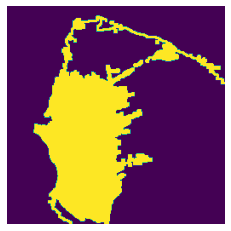

In [40]:
#Detecting Contours To Create Mask
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros((256,256), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

plt.axis('off')
plt.imshow(masked)

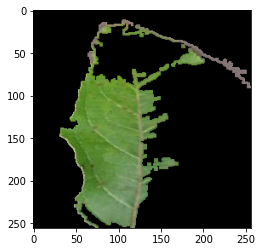

In [42]:
#Segmenting the Regions
dst = cv2.bitwise_and(img, img, mask=mask)
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(segmented)

## 3. Image Segmentation using Color Masking

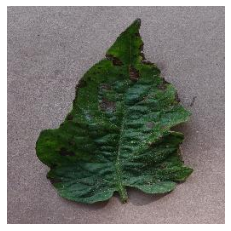

In [49]:
from skimage.filters import threshold_otsu
img2=cv2.imread('../input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight3.JPG')
img = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)

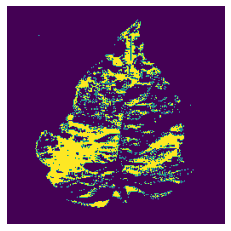

In [50]:
#Create Mask by Detecting Color
low = np.array([0, 0, 0])
high = np.array([215, 51, 51])

mask = cv2.inRange(img, low, high)

plt.axis('off')
plt.imshow(mask)

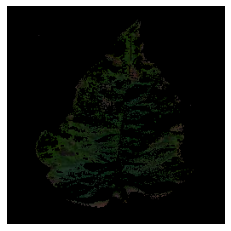

In [51]:
#Apply the Mask
result = cv2.bitwise_and(img, img, mask=mask)

plt.axis('off')
plt.imshow(result)

# Create model using CNN

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit_generator(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=20,
                         validation_steps=valid_num//batch_size,
                         )

# Summery of our model

In [ ]:
model.summary()

In [ ]:
model.save("Plant_final_1.h5")

# Confusion Matrix

In [ ]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Load Model

In [15]:
model=tf.keras.models.load_model('../input/plant-final-1/Plant_final_1.h5')

# Predict the model using validation dataset

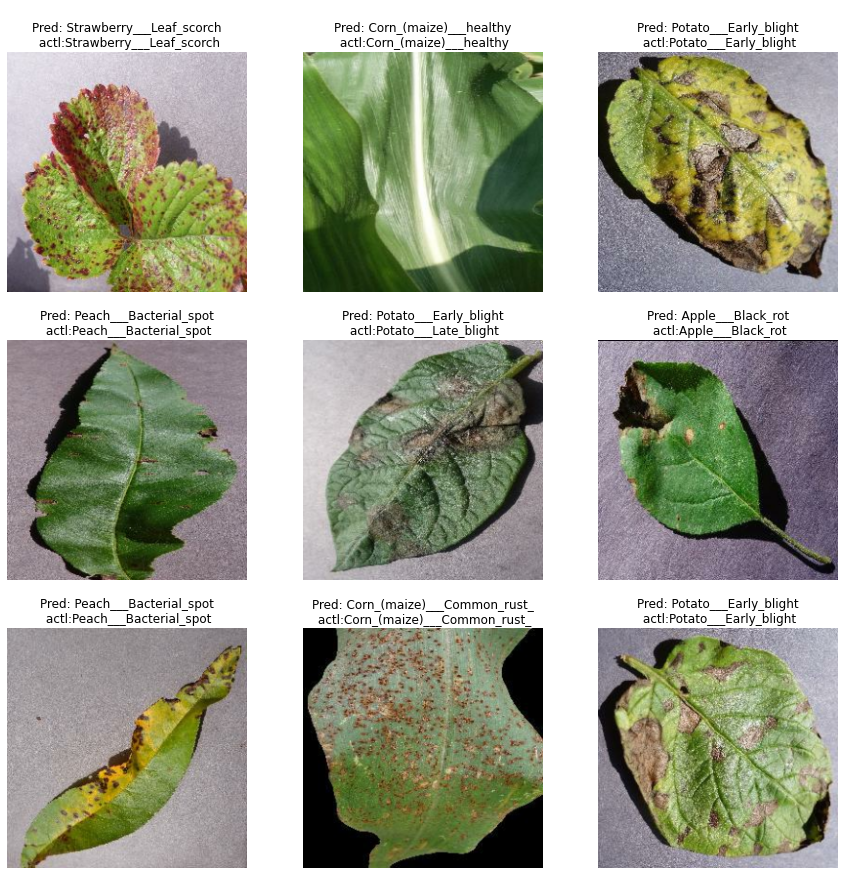

In [8]:
AccuracyVector = []
plt.figure(figsize=(15, 15))
for images, labels in validation_ds.take(1):
    
    predictions =model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
#     print(predlabel)
#     print(prdlbl)
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('\nPred: '+ predlabel[i]+"\n"+' actl:'+class_names[labels[i]] )
        #plt.title(f"Actual: {class_names[labels[i]]},\n Predicted: {predlabel[i]}.\n")
        plt.axis('off')
        plt.grid(True)

# Predict the model using training dataset

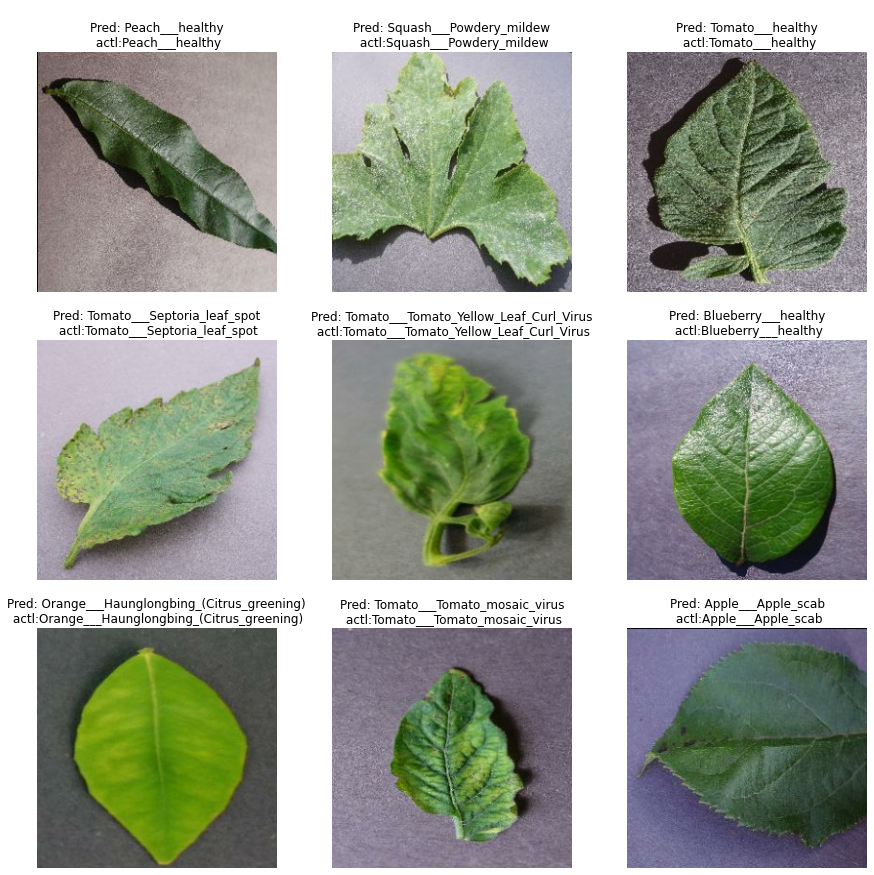

In [8]:
AccuracyVector = []
plt.figure(figsize=(15, 15))
for images, labels in training_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('\nPred: '+ predlabel[i]+"\n"+' actl:'+class_names[labels[i]] )
        #plt.title(f"Actual: {class_names[labels[i]]},\n Predicted: {predlabel[i]}.\n")
        plt.axis('off')
        plt.grid(True)

In [9]:
test_path="../input/new-plant-diseases-dataset/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
   test_path,
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 33 files belonging to 1 classes.


In [29]:
class_names1 = test_ds.class_names
print(class_names1)
print("\nTotal disease classes are: {}".format(len(class_names1)))

['test']

Total disease classes are: 1


In [30]:
print(type(test_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


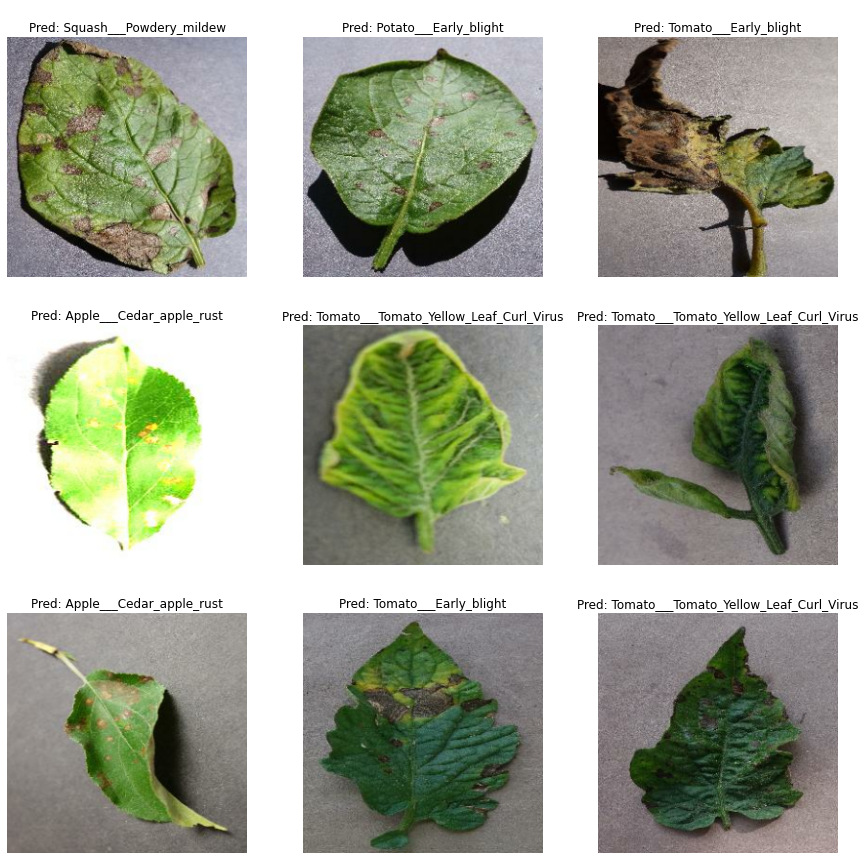

In [20]:
AccuracyVector = []
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    #print(labels)
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    #print(labels)

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    #print(predlabel)
    #print(prdlbl)
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('\nPred: '+ predlabel[i])      #+"\n"+' actl:'+class_names1[labels[i]] )
        #plt.title(f"Actual: {class_names[labels[i]]},\n Predicted: {predlabel[i]}.\n")
        plt.axis('off')
        plt.grid(True)

In [16]:
Classes = ["Apple___Apple_scab", 
           "Apple___Black_rot", 
           "Apple___Cedar_apple_rust", 
           "Apple___healthy", 
           "Blueberry___healthy", 
           "Cherry_(including_sour)___Powdery_mildew", 
           "Cherry_(including_sour)___healthy",
           "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", 
           "Corn_(maize)___Common_rust",  
           "Corn_(maize)___Northern_Leaf_Blight", 
           "Corn_(maize)___healthy",
           "Grape___Black_rot", 
           "Grape___Esca_(Black_Measles)", 
           "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",  
           "Grape___healthy",
           "Orange___Haunglongbing_(Citrus_greening)", 
           "Peach___Bacterial_spot", 
           "Peach___healthy", 
           "Pepper__bell___Bacterial_spot", 
           "Pepper__bell___healthy", 
           "Potato___Early_blight",
           "Potato___Late_blight",
           "Potato___healthy",
           "Raspberry___healthy", 
           "Soybean___healthy", 
           "Squash___Powdery_mildew", 
           "Strawberry___Leaf_scorch",
           "Strawberry___healthy",
           "Tomato___Bacterial_spot",
           "Tomato___Early_blight",
           "Tomato___Late_blight",
           "Tomato___Leaf_Mold",
           "Tomato___Septoria_leaf_spot",
           "Tomato___Spider_mites Two-spotted_spider_mite",
           "Tomato___Target_Spot",
           "Tomato___Tomato_Yellow_Leaf_Curl_Virus" ,
           "Tomato___Tomato_mosaic_virus",
           "Tomato___healthy",
           ]

# Single image prediction

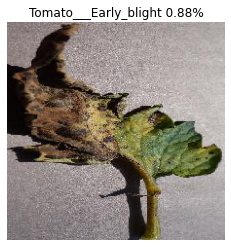

In [18]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory="../input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG"
#files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))] 

#for i in range(0,5):
image_path = directory
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
prediction = model.predict(img)
    #print(prediction)
probabilty = prediction.flatten()
    #print(probabilty)
max_prob = probabilty.max()
index=prediction.argmax(axis=-1)[0]
    #print(index)
class_name = Classes[index]
    #print(class_name)
    #ploting image with predicted class name        
plt.figure(figsize = (4,4))
    #ax = plt.subplot(3,3, i + 1)
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
plt.show()

# <center>**Thank you**</center>